<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
<h1>ШАГ 1</h1>
    <p>Поставлена задача: определить какой тариф прибыльнее для компании.
    <p>В распоряжении у нас есть несколько файлов - баз данных по 500 пользователям за 2018 год. Загрузим эти файлы в оперативную память.
</div>

In [1]:
import pandas as pd
import numpy as np
import math as mt
from matplotlib import pyplot as plt
from scipy import stats as st

df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p>Все данные успешно загрузились. Просмотрим содержимое файла 'calls.csv'
</div>

In [2]:
df_calls.info()
display(df_calls.head())
df_calls.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p>Файл содержит 202607 строк и 4 столбца: id, дату, продолжительность, идентификатор пользователя. Данные не содержат пропусков. Названия столбцов корректны.
    <p>Данные столбца call_date изменим на формат datetime для удобства
    <p>Продолжительность разговора округлим до целых минут в большую сторону (Мегалайн всегда округляет секунды до минут)
</div>

In [3]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls['duration'] = df_calls['duration'].apply(mt.ceil)

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p>Просмотрим содержимое файла internet.csv
</div>

In [4]:
df_internet.info()
display(df_internet.head())
df_internet.columns

# Ищем нули
df_internet.describe()
print(df_internet.query('mb_used == 0').count())
display(df_internet.query('mb_used == 0').head(10))
# посмотрим каким тарифом пользовались пользователи с нулями в столбце mb_used
df_merge = df_internet.query('mb_used == 0').merge(df_users, on='user_id')
print('Количество пользователей с 0 интернет-траффиком и тарифом "ULTRA" - {} или {:.0%}'
      .format(df_merge.query('tariff == "ultra"')['tariff'].count(), df_merge.query('tariff == "ultra"')['tariff'].count()/len(df_merge)))
print('Количество пользователей с 0 интернет-траффиком и тарифом "SMART" - {} или {:.0%}'
      .format(df_merge.query('tariff == "smart"')['tariff'].count(), df_merge.query('tariff == "smart"')['tariff'].count()/len(df_merge)))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Unnamed: 0      19598
id              19598
mb_used         19598
session_date    19598
user_id         19598
dtype: int64


,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0.0,2018-08-28,1000
38,38,1000_38,0.0,2018-11-27,1000
46,46,1000_46,0.0,2018-06-30,1000
67,67,1000_67,0.0,2018-06-16,1000
72,72,1000_72,0.0,2018-06-15,1000
103,103,1000_103,0.0,2018-05-26,1000
111,111,1000_111,0.0,2018-09-01,1000
131,131,1000_131,0.0,2018-06-15,1000
143,143,1000_143,0.0,2018-12-29,1000
157,157,1000_157,0.0,2018-07-11,1000


Количество пользователей с 0 интернет-траффиком и тарифом "ULTRA" - 1775 или 9%
Количество пользователей с 0 интернет-траффиком и тарифом "SMART" - 17823 или 91%


<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p>Файл содержит 149396 строк и 5 столбцов: 
        <li>Unnamed: 0 - колонка дублирует номера строк, вероятно ее нужно дропнуть, 
        <li>id (в том же формате что и в предыдущем файле), 
        <li>mb_used - использованное количество мегабайт,
        <li>session_date - дата сессии
        <li>user_id - идентификатор пользователя.
    <p>Убирем столбец с именем unnamed: 0 и изменим формат данных даты на datetime
</div>

<div style="color: white; border:solid green 2px; padding: 20px; background: #1fbcd1">
<li> В столбце mb_used есть нули в количестве 19598, при этом остальные данные целые. Вероятно пользователи не пользовались интернетом вообще или у них не было такой возможности.
<li> Если то, как распределяются пользователи, не использующие интернет-трафик, между тарифами, то 10% - это пользователи более дорогостоящего тарифа, а 90 - smart.

In [5]:
df_internet = df_internet.drop('Unnamed: 0', 1)
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')


<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p>Просмотрим содержимое файла messages.csv
</div>

In [6]:
df_messages.info()
display(df_messages.head())
df_messages.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Index(['id', 'message_date', 'user_id'], dtype='object')

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p>Файл содержит 123036 строк, с временем и идентификатором пользователя - вероятно когда и кем было отправлено сообщение. Пропусков нет, названия столбцов корректные.
    <p>Заменим дату сообщений на формат datatime
</div>

In [7]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p>Просмотрим содержимое файла tariffs.csv
</div>

In [8]:
df_tariffs.info()
display(df_tariffs.head())
df_tariffs.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name'],
      dtype='object')

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p>Файл содержит 2 строки - данные по двум тарифам: сколько включено сообщений, мегабайт, минут, ежемесячная оплата, дополнительная плата за ГБ, стоимость одного сообщения, минуты и название тарифа. Пропусков данных нет, названия столбцов корректные.
    <p>Просмотрим содержимое файла users.csv
</div>

In [9]:
df_users.info()
display(df_users.head())
df_users.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p>Последний файл содержит данные 500 пользователей: user_id, возраст, дата отключения тарифа (есть пропуски, но по условию пропуск означает что тариф все еще подключен - на момент выгрузки базы данных), город, имя и фамилия, дата подключения тарифа, тариф.
</div>

In [10]:
df_users['churn_date'] = df_users['churn_date'].fillna('2018-12-31')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

**Вывод:**
<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Таким образом, у нас есть несколько таблиц, в которых есть смежные данные (user_id). Для дальнейшего анализа планируется соединить эти таблицы в одну.
</div>

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
<h1>ШАГ 2: Подготовка данных</h1>
    <p> В таблицах calls, messges и internet добавим столбец с номером месяца
    <p> Возьмем за основу таблицу df_users.
    <p> Соединим таблицу df_users c df_calls, df_messages и df_internet 
    <p> Затем соединим получившиеся таблицы первую ко второй, вторую к третей.
    <p> Сделаем необходимые расчеты
</div>

In [11]:
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Создадим сводную таблицу df_calls по user_id и month, значение duration агрегируем функциями sum (сумма минут или продолжительность разговора) и count (количество звонков) за соответствующий месяц
</div>

In [12]:
df_calls = df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count'], fill_value=0)
df_calls.head(10)


sum    count
              duration duration
user_id month                  
1000    5          159       22
        6          172       43
        7          340       47
        8          408       52
        9          466       58
        10         350       57
        11         338       43
        12         333       46
1001    11         430       59
        12         414       63

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Сделаем названия столбцом одноэтажными и обновим индекс
</div>

In [13]:
df_calls.columns = ['duration_sum', 'calls_count']
df_calls = df_calls.reset_index()
df_calls.head(10)

,user_id,month,duration_sum,calls_count
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58
5,1000,10,350,57
6,1000,11,338,43
7,1000,12,333,46
8,1001,11,430,59
9,1001,12,414,63


<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Сделаем то же самое с таблицей df_message. В ней агрегируем по id (количество сообщений), заменим название столбца id на count.
</div>

In [14]:
df_messages = df_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
df_messages = df_messages.rename(columns={'id':'count_msg'}).reset_index()

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Сделаем то же самое с таблицей df_internet. В ней агрегируем по mb_used (сумма мегабайт), затем создадим новый столбец и в нем переведем значение мб в ГБ.
</div>

In [15]:
df_internet = df_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()
df_internet['gb_used'] = df_internet['mb_used'].apply(lambda x: mt.ceil(x/1024))

In [16]:
df_internet.head()

,user_id,month,mb_used,gb_used
0,1000,5,2253.49,3
1,1000,6,23233.77,23
2,1000,7,14003.64,14
3,1000,8,14055.93,14
4,1000,9,14568.91,15


<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Соединим таблицу df_users с таблицами: 1 - df_calls, 2 - df_messages, 3 - df_internet паралельно.
    <p> А затем через join соединим в единый df таблицы 1 с 2, затем с 3
    <p> Посмотрим на структуру получившейся таблицы через info
</div

In [17]:
# здесь был предыдущий неверный код, я его случайно удалил, прошу прощенья

df_tmp = df_calls.merge(df_messages, on=['user_id', 'month'], how='outer')
df_tmp = df_tmp.merge(df_internet, on=['user_id', 'month'], how='outer')
df2 = df_tmp.merge(df_users, on=['user_id'], how='outer')

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 14 columns):
user_id         3216 non-null int64
month           3214 non-null float64
duration_sum    3174 non-null float64
calls_count     3174 non-null float64
count_msg       2717 non-null float64
mb_used         3203 non-null float64
gb_used         3203 non-null float64
age             3216 non-null int64
churn_date      3216 non-null datetime64[ns]
city            3216 non-null object
first_name      3216 non-null object
last_name       3216 non-null object
reg_date        3216 non-null datetime64[ns]
tariff          3216 non-null object
dtypes: datetime64[ns](2), float64(6), int64(2), object(4)
memory usage: 376.9+ KB


In [18]:
df2 = df2.drop(columns='mb_used')

lst = ['month', 'duration_sum', 'calls_count', 'count_msg', 'gb_used']
for x in lst:
    df2[x] = df2[x].fillna(0).astype('int')

df2 = df2.query('month != 0')
df2.info()
df2.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 13 columns):
user_id         3214 non-null int64
month           3214 non-null int64
duration_sum    3214 non-null int64
calls_count     3214 non-null int64
count_msg       3214 non-null int64
gb_used         3214 non-null int64
age             3214 non-null int64
churn_date      3214 non-null datetime64[ns]
city            3214 non-null object
first_name      3214 non-null object
last_name       3214 non-null object
reg_date        3214 non-null datetime64[ns]
tariff          3214 non-null object
dtypes: datetime64[ns](2), int64(7), object(4)
memory usage: 351.5+ KB


,user_id,month,duration_sum,calls_count,count_msg,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,159,22,22,3,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,172,43,60,23,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,340,47,75,14,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,408,52,81,14,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,466,58,57,15,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
5,1000,10,350,57,73,15,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
6,1000,11,338,43,58,15,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
7,1000,12,333,46,70,10,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
8,1001,11,430,59,0,18,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart
9,1001,12,414,63,0,14,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart


<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Получилось много столбцов-дубликатов, убирем их методом drop 
</div

In [19]:
# df2 = df2.drop(['user_id_x', 
#                 'age_x', 
#                 'churn_date_x', 
#                 'city_x', 
#                 'first_name_x', 
#                 'last_name_x', 
#                 'reg_date_x',
#                 'tariff_x', 
#                 'month_x', 
#                 'user_id_y', 
#                 'age_y',
#                 'churn_date_y', 
#                 'city_y', 
#                 'first_name_y', 
#                 'last_name_y', 
#                 'reg_date_y',
#                 'tariff_y', 
#                 'month_y', 
#                 'mb_used'
#                ], axis = 1)
# df2.info()

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Сформировались пропуски, посмотрим на строки с этими пропусками (по столбцу month)
</div

In [20]:
# print('Количество пропусков = {:.04%}'.format(df2['month'].isna().mean()))
# df2.query('month != month')

<div style="color: white; border:solid green 2px; padding: 20px; background: #1fbcd1">

<p> Оставим лишь те столбцы с которыми будем работать дальше

In [21]:
df2 = df2[['user_id', 'city', 'month', 'duration_sum', 'calls_count', 'count_msg', 'gb_used', 'tariff']]
df2.info()
df2.head(50)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
user_id         3214 non-null int64
city            3214 non-null object
month           3214 non-null int64
duration_sum    3214 non-null int64
calls_count     3214 non-null int64
count_msg       3214 non-null int64
gb_used         3214 non-null int64
tariff          3214 non-null object
dtypes: int64(6), object(2)
memory usage: 226.0+ KB


,user_id,city,month,duration_sum,calls_count,count_msg,gb_used,tariff
0,1000,Краснодар,5,159,22,22,3,ultra
1,1000,Краснодар,6,172,43,60,23,ultra
2,1000,Краснодар,7,340,47,75,14,ultra
3,1000,Краснодар,8,408,52,81,14,ultra
4,1000,Краснодар,9,466,58,57,15,ultra
5,1000,Краснодар,10,350,57,73,15,ultra
6,1000,Краснодар,11,338,43,58,15,ultra
7,1000,Краснодар,12,333,46,70,10,ultra
8,1001,Москва,11,430,59,0,18,smart
9,1001,Москва,12,414,63,0,14,smart


<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Если неизвестен месяц, то это данные не к чему присовокупить и их не так уж и много - около 1%. Исключим их из датасета.
</div

In [22]:
# df2 = df2.query('month == month')

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Посмотрим какие пропуски остались
</div

In [23]:
# display(df2.isna().mean())
# df2.info()

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Остались пропуски в столбце count_msg 15% и gb_used менее 1%. Если данных в этих ячейках нет, вероятнее всего их и не было. Заполним их нулями.
</div

In [24]:
# df2['count_msg'] = df2['count_msg'].fillna(0)
# df2['gb_used'] = df2['gb_used'].fillna(0)

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Для того, чтобы определить помесячную вырочку для каждого пользователя, создадим в датасете новый параметр - profit. Также создадим функцию, которая заполнит ячейки в этом параметре (используем функцию одной строки). Данные по тарифам возьмем из df_tariff.
</div

In [25]:
df_tariffs = df_tariffs.rename(columns={'tariff_name':'tariff'})
df2 = df2.merge(df_tariffs, on='tariff').sort_values('user_id').set_index('user_id')
df2.head(20)

,city,month,duration_sum,calls_count,count_msg,gb_used,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
user_id,,,,,,,,,,,,,,
1000,Краснодар,5,159,22,22,3,ultra,1000,30720,3000,1950,150,1,1
1000,Краснодар,6,172,43,60,23,ultra,1000,30720,3000,1950,150,1,1
1000,Краснодар,7,340,47,75,14,ultra,1000,30720,3000,1950,150,1,1
1000,Краснодар,8,408,52,81,14,ultra,1000,30720,3000,1950,150,1,1
1000,Краснодар,9,466,58,57,15,ultra,1000,30720,3000,1950,150,1,1
1000,Краснодар,10,350,57,73,15,ultra,1000,30720,3000,1950,150,1,1
1000,Краснодар,11,338,43,58,15,ultra,1000,30720,3000,1950,150,1,1
1000,Краснодар,12,333,46,70,10,ultra,1000,30720,3000,1950,150,1,1
1001,Москва,12,414,63,0,14,smart,50,15360,500,550,200,3,3


In [26]:
# def profit_f(row):
#     if row['tariff'] == 'ultra':
#       profit_calls_duration = max(0, row['duration_sum'] - row['minutes_included']) 
#       profit_count_msg = max(0, row['count_msg'] - row['messages_included']) 
#       profit_gb_used = max(0, (row['gb_used'] - row['mb_per_month_included']//1024) * 150)
#       return profit_calls_duration + profit_count_msg + profit_gb_used + row['rub_monthly_fee']
    
def profit_f(row):
      profit_calls_duration = max(0, row['duration_sum'] - row['minutes_included']) * row['rub_per_minute']
      profit_count_msg = max(0, row['count_msg'] - row['messages_included']) * row['rub_per_message']
      profit_gb_used = max(0, (row['gb_used'] - row['mb_per_month_included']//1024)) * row['rub_per_gb']
      return profit_calls_duration + profit_count_msg + profit_gb_used + row['rub_monthly_fee']

df2['profit'] = df2.apply(profit_f, axis = 1)
df2 = df2.drop(['messages_included',
                'mb_per_month_included', 
                'minutes_included', 
                'rub_monthly_fee', 
                'rub_per_gb', 
                'rub_per_message', 
                'rub_per_minute'], axis=1) 
df2.head(15)

,city,month,duration_sum,calls_count,count_msg,gb_used,tariff,profit
user_id,,,,,,,,
1000,Краснодар,5,159,22,22,3,ultra,1950
1000,Краснодар,6,172,43,60,23,ultra,1950
1000,Краснодар,7,340,47,75,14,ultra,1950
1000,Краснодар,8,408,52,81,14,ultra,1950
1000,Краснодар,9,466,58,57,15,ultra,1950
1000,Краснодар,10,350,57,73,15,ultra,1950
1000,Краснодар,11,338,43,58,15,ultra,1950
1000,Краснодар,12,333,46,70,10,ultra,1950
1001,Москва,12,414,63,0,14,smart,550


<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Создадим сводную таблицу df2_pivot в которой сведем информацию по индексам user_id, и колонкам tariff, агрегируем данные по продолжительности и количества звонков, количеству смс и инет-трафика, выведя среднее значение по всем месяцам. И выведем на экран.
</div>

In [27]:
# df2_pivot = df2.pivot_table(index=['user_id'], columns='tariff', values=['duration_sum', 'calls_count', 'count_msg', 'gb_used', 'profit'], aggfunc=('mean'))

df2_pivot = df2.pivot_table(index=['user_id'], values=['duration_sum', 'calls_count', 'count_msg', 'gb_used', 'profit'], aggfunc=('mean'))

df2_pivot.head(10)


,calls_count,count_msg,duration_sum,gb_used,profit
user_id,,,,,
1000,46.0,62.0,320.750000,13.625000,1950.000000
1001,61.0,0.0,422.000000,16.000000,850.000000
1002,31.0,10.0,216.714286,16.714286,1035.714286
1003,104.0,76.0,764.400000,11.800000,1950.000000
1004,22.0,149.0,123.375000,18.750000,1950.000000
1005,74.0,46.0,550.416667,8.583333,827.000000
1006,46.0,0.0,318.272727,15.090909,931.818182
1007,68.0,25.0,486.555556,14.888889,913.444444
1008,52.0,56.0,339.000000,13.000000,568.000000


<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Для упрощения восприятия заменим мультииндекс на одноэтажный
</div>

In [28]:
# df2_pivot.columns = [
#                      'cnt_msg_smart', 'cnt_msg_ultra', 
#                      'calls_cnt_smart', 'calls_cnt_ultra', 
#                      'calls_duration_smart', 'calls_duration_ultra', 
#                      'gb_smart', 'gb_ultra', 
#                      'profit_smart', 'profit_ultra'
#                     ]

# df2_pivot.reset_index(level=0)

**Вывод:**

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Обработав данные во втором шаге мы получили сводную таблицу, где предоставлены данные по количеству и продолжительности звонков,
        по количеству смс и интернет тарфику. Значения данных в столбцах представлены средними значениями за месяц и в итоговой таблице среднее за все месяцы.
    <p> Из этой таблицы получены данные (Series) - выборки для двух тарифов, которые нужно сравнить, данные очищены от пропусков и приведены к целочисленному значению.
</div>
#
<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
<h1>ШАГ 3: Анализ данных</h1>
    <p> Определим сколько минут разговора, смс и интернет трафика требуется каждому пользователю тарифом в месяц
</div>

In [29]:
# msg_smart = df2_pivot['cnt_msg_smart'].dropna().astype('int')
# msg_ultra = df2_pivot['cnt_msg_ultra'].dropna().astype('int')
# calls_count_smart = df2_pivot['calls_cnt_smart'].dropna().astype('int')
# calls_count_ultra = df2_pivot['calls_cnt_ultra'].dropna().astype('int')
# calls_duration_smart = df2_pivot['calls_duration_smart'].dropna().astype('int')
# calls_duration_ultra = df2_pivot['calls_duration_ultra'].dropna().astype('int')
# gb_smart = df2_pivot['gb_smart'].dropna().astype('int')
# gb_ultra = df2_pivot['gb_ultra'].dropna().astype('int')

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Определим объемы выборок - сколько элементов в каждой
</div>

In [30]:
# print('SMART = ', len(df2.query('tariff == "smart"')))
# print('ULTRA = ', len(df2.query('tariff == "ultra"')))

print('SMART = ', len(df2.query('tariff == "smart"').reset_index()['user_id']))
print('ULTRA = ', len(df2.query('tariff == "ultra"').reset_index()['user_id']))

df2.head()

SMART =  2229
ULTRA =  985


,city,month,duration_sum,calls_count,count_msg,gb_used,tariff,profit
user_id,,,,,,,,
1000,Краснодар,5,159,22,22,3,ultra,1950
1000,Краснодар,6,172,43,60,23,ultra,1950
1000,Краснодар,7,340,47,75,14,ultra,1950
1000,Краснодар,8,408,52,81,14,ultra,1950
1000,Краснодар,9,466,58,57,15,ultra,1950


<div style="color: white; border:solid green 2px; padding: 20px; background: #ff4500">
    <b>Реакция на комментарий 2</b>
<p> Исправил, вроде как-то так... Без reset_index() ошибку выдавал, пришлось добавить

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера 3</h2>
    
Да, без сброса индекса не получится, потому что индексом является id, который мы и хотим получить. 
    
    
Не, я имела в виду список уникальных. То есть просто число клиентов. А то в нашей таблице число строк зависит от числа месяцев, в течение которых клиент подключен: </div>

In [43]:
# КОД РЕВЬЮЕРА

df2.reset_index().groupby('tariff')['user_id'].nunique()

tariff
smart    350
ultra    148
Name: user_id, dtype: int64

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Люди предпочитают тариф SMART тарифу ULTRA, вероятно более низкой его стоимости
</div>


SMART - среднее количество смс = 33 шт.
SMART - среднее количество смс - дисперсия = 796.8129584480083
SMART - среднее количество смс - стандартное отклонение = 28.221542886898938

ULTRA - среднее количество смс = 49 шт.
ULTRA - среднее количество смс - дисперсия 2285.266142544674
ULTRA - среднее количество смс - стандартное отклонение = 47.78018496610161



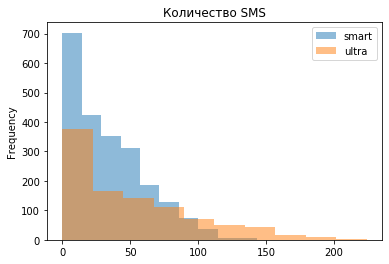

In [31]:
# msg_smart.plot.hist(alpha=.5, label='smart', legend=True, title='Количество SMS')
# msg_ultra.plot.hist(alpha=.5, label='ultra', legend=True)
# print()
# print('SMART - среднее количество смс = {} шт.'.format(int(msg_smart.mean())))
# print('SMART - среднее количество смс - дисперсия = {}'.format(np.var(msg_smart, ddof=1)))
# print('SMART - среднее количество смс - стандартное отклонение = {}'.format(np.std(msg_smart)))
# print()
# print('ULTRA - среднее количество смс = {} шт.'.format(int(msg_ultra.mean())))
# print('ULTRA - среднее количество смс - дисперсия {}'.format(np.var(msg_ultra, ddof=1)))
# print('ULTRA - среднее количество смс - стандартное отклонение = {}'.format(np.std(msg_ultra)))
# print()

df2.query('tariff == "smart"')['count_msg'].plot.hist(alpha=.5, label='smart', legend=True, title='Количество SMS')
df2.query('tariff == "ultra"')['count_msg'].plot.hist(alpha=.5, label='ultra', legend=True)
print()
print('SMART - среднее количество смс = {} шт.'.format(int(df2.query('tariff == "smart"')['count_msg'].mean())))
print('SMART - среднее количество смс - дисперсия = {}'.format(np.var(df2.query('tariff == "smart"')['count_msg'], ddof=1)))
print('SMART - среднее количество смс - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "smart"')['count_msg'])))
print()
print('ULTRA - среднее количество смс = {} шт.'.format(int(df2.query('tariff == "ultra"')['count_msg'].mean())))
print('ULTRA - среднее количество смс - дисперсия {}'.format(np.var(df2.query('tariff == "ultra"')['count_msg'], ddof=1)))
print('ULTRA - среднее количество смс - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "ultra"')['count_msg'])))
print()

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> В среднем пользователям тарифа СМАРТ требуется до 150 смс в месяц, в среднем 33, при этом они редко используют более 120 смс. Возможно это связано с ограничением включенных в тариф смс - 50 в месяц.
    <p> Пользователи тарифа УЛЬТРА пользуются смс-ками до 200 в месяц со средним в 49 штук в месяц. 
    <p> Дисперсии обладателей тарифов по использованию смс отличаются в 3 раза (больше дисперсия у пользователей УЛЬТРА, что говорит о большем разбросе значений, т.е. они более свободны в выборе - куда и сколько потратить смс).
        



SMART - среднее количество звонков = 58 шт.
SMART - среднее количество звонков - дисперсия 672.8762433017358
SMART - среднее количество звонков - стандартное отклонение = 25.934038823652493

ULTRA - среднее количество звонков = 73 шт.
ULTRA - среднее количество звонков - дисперсия 1928.6899900953324
ULTRA - среднее количество звонков - стандартное отклонение = 43.89455466446473



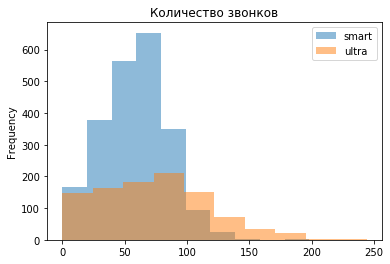

In [32]:
# calls_count_smart.plot.hist(alpha=.5, label='smart', legend=True, title='Количество звонков')
# calls_count_ultra.plot.hist(alpha=.5, label='ultra', legend=True)
# print()
# print('SMART - среднее количество звонков = {} шт.'.format(int(calls_count_smart.mean())))
# print('SMART - среднее количество звонков - дисперсия {}'.format(np.var(calls_count_smart, ddof=1)))
# print('SMART - среднее количество звонков - стандартное отклонение = {}'.format(np.std(calls_count_smart)))
# print()
# print('ULTRA - среднее количество звонков = {} шт.'.format(int(calls_count_ultra.mean())))
# print('ULTRA - среднее количество звонков - дисперсия {}'.format(np.var(calls_count_ultra, ddof=1)))
# print('ULTRA - среднее количество звонков - стандартное отклонение = {}'.format(np.std(calls_count_ultra)))
# print()

df2.query('tariff == "smart"')['calls_count'].plot.hist(alpha=.5, label='smart', legend=True, title='Количество звонков')
df2.query('tariff == "ultra"')['calls_count'].plot.hist(alpha=.5, label='ultra', legend=True)
print()
print('SMART - среднее количество звонков = {} шт.'.format(int(df2.query('tariff == "smart"')['calls_count'].mean())))
print('SMART - среднее количество звонков - дисперсия {}'.format(np.var(df2.query('tariff == "smart"')['calls_count'], ddof=1)))
print('SMART - среднее количество звонков - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "smart"')['calls_count'])))
print()
print('ULTRA - среднее количество звонков = {} шт.'.format(int(df2.query('tariff == "ultra"')['calls_count'].mean())))
print('ULTRA - среднее количество звонков - дисперсия {}'.format(np.var(df2.query('tariff == "ultra"')['calls_count'], ddof=1)))
print('ULTRA - среднее количество звонков - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "ultra"')['calls_count'])))
print()

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> У обладателей тарифа СМАРТ среднее количество звонков 58 шт/мес, у обладателей УЛЬТРА среднее количество 73 звонка. 
    <p> Дисперсия по этому параметру больше у тарифа УЛЬТРА в 3 раза.
</div>


SMART - средняя продолжительность звонков = 417 мин
SMART - средняя продолжительность звонков - дисперсия 36219.31578434428
SMART - средняя продолжительность звонков - стандартное отклонение = 190.27103471651876

ULTRA - средняя продолжительность звонков = 526 мин
ULTRA - средняя продолжительность звонков - дисперсия 100873.63339730098
ULTRA - средняя продолжительность звонков - стандартное отклонение = 317.44483554974113



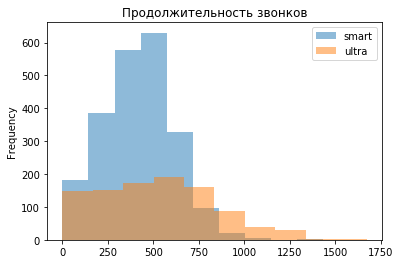

In [33]:
# calls_duration_smart.plot.hist(alpha=.5, label='smart', legend=True, title='Продолжительность звонков')
# calls_duration_ultra.plot.hist(alpha=.5, label='ultra', legend=True)
# print()
# print('SMART - средняя продолжительность звонков = {} мин'.format(int(calls_duration_smart.mean())))
# print('SMART - средняя продолжительность звонков - дисперсия {}'.format(np.var(calls_duration_smart, ddof=1)))
# print('SMART - средняя продолжительность звонков - стандартное отклонение = {}'.format(np.std(calls_duration_smart)))
# print()
# print('ULTRA - средняя продолжительность звонков = {} мин'.format(int(calls_duration_ultra.mean())))
# print('ULTRA - средняя продолжительность звонков - дисперсия {}'.format(np.var(calls_duration_ultra, ddof=1)))
# print('ULTRA - средняя продолжительность звонков - стандартное отклонение = {}'.format(np.std(calls_duration_ultra)))
# print()

df2.query('tariff == "smart"')['duration_sum'].plot.hist(alpha=.5, label='smart', legend=True, title='Продолжительность звонков')
df2.query('tariff == "ultra"')['duration_sum'].plot.hist(alpha=.5, label='ultra', legend=True)
print()
print('SMART - средняя продолжительность звонков = {} мин'.format(int(df2.query('tariff == "smart"')['duration_sum'].mean())))
print('SMART - средняя продолжительность звонков - дисперсия {}'.format(np.var(df2.query('tariff == "smart"')['duration_sum'], ddof=1)))
print('SMART - средняя продолжительность звонков - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "smart"')['duration_sum'])))
print()
print('ULTRA - средняя продолжительность звонков = {} мин'.format(int(df2.query('tariff == "ultra"')['duration_sum'].mean())))
print('ULTRA - средняя продолжительность звонков - дисперсия {}'.format(np.var(df2.query('tariff == "ultra"')['duration_sum'], ddof=1)))
print('ULTRA - средняя продолжительность звонков - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "ultra"')['duration_sum'])))
print()

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> По продолжительности звонков пользователем тарифа смарт обычно требуется от 200 до 750 минут в месяц, в среднем 417 мин (500 минут включено в тарифный план). В то же время пользователи тарифа УЛЬТРА в среднем разговаривают чуть больше  - от 0 до 1000 минут, в среднем 526 минут. Но 3000 минут (включенные минуты в тариф) никто не проговорил...
    <p> При этом дисперсия по продолжительности звонков больше у тарифа ультра - они могут позволить себе дольше говорить по телефону, поскольку у них меньше ограничений (3000 минут включенных в тарифный план).
</div>


SMART - интернет трафик = 16 Гб/мес
SMART - интернет трафик - дисперсия 33.02870517811161
SMART - интернет трафик - стандартное отклонение = 5.745771267187499

ULTRA - интернет трафик = 19 Гб/мес
ULTRA - интернет трафик - дисперсия 97.09168626965459
ULTRA - интернет трафик - стандартное отклонение = 9.848508314957495



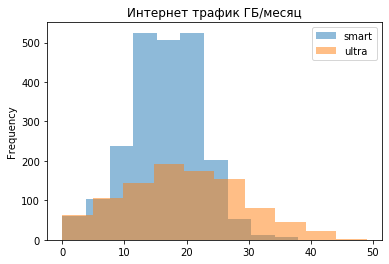

In [34]:
# gb_smart.plot.hist(alpha=.5, label='smart', legend=True, title='Интернет трафик ГБ/месяц')
# gb_ultra.plot.hist(alpha=.5, label='ultra', legend=True)
# print()
# print('SMART - интернет трафик = {} Гб/мес'.format(int(gb_smart.mean())))
# print('SMART - интернет трафик - дисперсия {}'.format(np.var(gb_smart, ddof=1)))
# print('SMART - интернет трафик - стандартное отклонение = {}'.format(np.std(gb_smart)))
# print()
# print('ULTRA - интернет трафик = {} Гб/мес'.format(int(gb_ultra.mean())))
# print('ULTRA - интернет трафик - дисперсия {}'.format(np.var(gb_ultra, ddof=1)))
# print('ULTRA - интернет трафик - стандартное отклонение = {}'.format(np.std(gb_ultra)))
# print()

df2.query('tariff == "smart"')['gb_used'].plot.hist(alpha=.5, label='smart', legend=True, title='Интернет трафик ГБ/месяц')
df2.query('tariff == "ultra"')['gb_used'].plot.hist(alpha=.5, label='ultra', legend=True)
print()
print('SMART - интернет трафик = {} Гб/мес'.format(int(df2.query('tariff == "smart"')['gb_used'].mean())))
print('SMART - интернет трафик - дисперсия {}'.format(np.var(df2.query('tariff == "smart"')['gb_used'], ddof=1)))
print('SMART - интернет трафик - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "smart"')['gb_used'])))
print()
print('ULTRA - интернет трафик = {} Гб/мес'.format(int(df2.query('tariff == "ultra"')['gb_used'].mean())))
print('ULTRA - интернет трафик - дисперсия {}'.format(np.var(df2.query('tariff == "ultra"')['gb_used'], ddof=1)))
print('ULTRA - интернет трафик - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "ultra"')['gb_used'])))
print()

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Интернетом более активно пользуются обладатели тарифа ULTRA в среднем 19 Гб/мес, обладатели SMART - в среднем 16 в месяц. Дисперсии отличаются в 3 раза (больше у обладателей ultra).
</div>

**Вывод:**

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Изучив данные выборок можно прийти к выводу что пользователи двух тарифов принципиально отличаются по пользованию СМС и продолжительностью терефонных разговоров. По интернет трафику и количеству звонков нет видимых различий.
</div>
#
<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
<h1>ШАГ 5: Проверка гипотез</h1>
</div>

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <h3> Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются</h3>
</div>

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Если средняя выручка тарифов не различаются, значит они относятся к одной генеральной совокупности 
        и их средние значения не выйдут за порог значения альфа = 0.5 (т.е. р-значение будет больше 0.5) - это нулевая гипотеза.
    <p> Произведем расчет:
</div>

In [35]:
profit_smart = df2.query('tariff == "smart"')['profit']
profit_ultra = df2.query('tariff == "ultra"')['profit']

alpha = .05
dif_profit_result = st.ttest_ind(profit_smart, profit_ultra)
print('p-значение = ', dif_profit_result.pvalue)

p-значение =  1.4229814360764067e-160


<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Мы имеем очень малое р-знаение (ноль!), что говорит о том, что средние выручки тарифов относятся к разным гененальным совокупностям (отвергаем нулевую гипотезу) и эти выручки значимо различаются.
    <p> Возьмем среднее значение чтобы узнать какой тариф лучше:
</div>

In [36]:
# print('SMART profit mean : ', profit_smart.mean())
# print('ULTRA profit mean : ', profit_ultra.mean())

print('SMART profit mean : {}'.format(df2.query('tariff == "smart"')['profit'].mean()))
print('ULTRA profit mean : {}'.format(df2.query('tariff == "ultra"')['profit'].mean()))

SMART profit mean : 1289.9735307312696
ULTRA profit mean : 2070.1522842639592


<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Выборки имеют статистические различия, и среднее значение прибыли по тарифу УЛЬТРА выше
</div>

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <h3> Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.</h3>
</div>

<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Нулевая гипотеза: Средняя выручка пользователей Москвы = среднней выручке других регионов.
    <p> Выделим 2 выборки: df_moscow и df_vne_moscow.
</div>

In [37]:
df_moscow = df2.query('city == "Москва"')
df_vne_moscow = df2.query('city != "Москва"')

In [38]:
df_moscow_pivot = df_moscow.pivot_table(index=['user_id'], values=['profit'], aggfunc=('mean'))
df_vne_moscow_pivot = df_vne_moscow.pivot_table(index=['user_id'], values=['profit'], aggfunc=('mean'))

In [39]:
# используем критейрий alpha = 0.1 для более точного результата (статистически значимого различия)

# alpha = .1
# alpha = .05

dif_profit_result = st.ttest_ind(df_moscow_pivot['profit'], df_vne_moscow_pivot['profit'])
print('p-значение = ', dif_profit_result.pvalue)

p-значение =  0.36094633224451433


<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> p-значение = 0.18 > 0.1 альфа, значит наша нулевая гипотеза не верна: средняя выручка в Москве не равна средней выручке в других регионах.
    <p> Проверим это, возьмем среднее по выборкам:
</div>

In [40]:
print('Средняя прибыль по одному клиенту по Москве: ', df_moscow_pivot['profit'].mean())
print('Средняя прибыль по одному клиенту по не Москве: ', df_vne_moscow_pivot['profit'].mean())

Средняя прибыль по одному клиенту по Москве:  1498.465851152215
Средняя прибыль по одному клиенту по не Москве:  1563.8822229636141


<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> В Москве прибыль выше.
</div>

### Вывод



<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Согласно статистическому анализу мы получили следующие данные:
        <li> Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
        <li> Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
</div>

<div style="color: white; border:solid green 2px; padding: 20px; background: #1fbcd1">
    <b>Вывод после исправления ошибок:</b>
<p> Средняя выручка пользователей тарифов "Ультра" и "Смарт" статистически различаются.
<p> Средняя выручка пользователей из Москвы и других регионов статистически одинаковы.
    
    

# Вывод
<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> В результате нашего исследования мы выяснили что тариф "УЛЬТРА" показал статистически значимые различия по отношение к тарифу "СМАРТ". 
    <p> Т.о. тариф "УЛЬТРА" прибыльнее тарифа "СМАРТ".
</div>


In [45]:

df2.pivot_table(index='tariff', values=['duration_sum', 'count_msg', 'gb_used'],
                       aggfunc=['mean', 'std', 'var'])

mean                                std                         \
        count_msg duration_sum    gb_used  count_msg duration_sum   gb_used   
tariff                                                                        
smart   33.384029   417.934948  16.328847  28.227876   190.313730  5.747061   
ultra   49.363452   526.623350  19.494416  47.804457   317.606098  9.853511   

                var                            
          count_msg   duration_sum    gb_used  
tariff                                         
smart    796.812958   36219.315784  33.028705  
ultra   2285.266143  100873.633397  97.091686

In [46]:
# КОД РЕВЬЮЕРА

# Это все для мультиндекса
l1 = ['duration_sum', 'count_msg', 'gb_used']
l2 = ['mean', 'var', 'std']
idx = pd.MultiIndex.from_product([l1, l2])


print(idx)

print('\n\n\nИндексы: ', idx[0], 'Первый: ', idx[0][0], 'Второй: ', idx[0][1])

df = pd.DataFrame(index=['smart', 'ultra'], columns=idx)

for i in df.columns:
    #  Срез по первому индексу, агрегирование — по второму. 
    df.loc['smart',i] = np.round(df2.query('tariff=="smart"')[i[0]].agg(i[1]),2)
    df.loc['ultra',i] = np.round(df2.query('tariff=="ultra"')[i[0]].agg(i[1]),2)
    
df    

MultiIndex([('duration_sum', 'mean'),
            ('duration_sum',  'var'),
            ('duration_sum',  'std'),
            (   'count_msg', 'mean'),
            (   'count_msg',  'var'),
            (   'count_msg',  'std'),
            (     'gb_used', 'mean'),
            (     'gb_used',  'var'),
            (     'gb_used',  'std')],
           )



Индексы:  ('duration_sum', 'mean') Первый:  duration_sum Второй:  mean


duration_sum                  count_msg                 gb_used         \
              mean      var     std      mean      var    std    mean    var   
smart       417.93  36219.3  190.31     33.38   796.81  28.23   16.33  33.03   
ultra       526.62   100874  317.61     49.36  2285.27   47.8   19.49  97.09   

             
        std  
smart  5.75  
ultra  9.85

# Вывод 
<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
<p> 1 - Было сделано предположение что тарифы статистически не различаются, (т.е. средние значения их выборок по тарифам относятся к одной генеральной совокупности). В результате статистического исследования оказалось что р-значение по двум выборочным совокупностям (средемесячной прибыли по 2 тарифам) выходит за пределы 5% (альфа 0.05) и равно 0 (или очень близкому к нулю значению). Это дает нам право право отвергнуть нулевую гипотезу - а именно тарифы статистически различаются по уровню прибыльности (но каким образом отличаются мы по этим данным сказать не можем). Учитывая что средние значения прибильности по месяцам у тарифа ultra в 2 раза выше чем у smart (1045 против 2070), то можно заключить что тариф ultra в 2 раза прибыльнее тарифа smart.
<p> 2 - Если рассмотреть прибыльность по Москве и регионам, то при статистическом исследовании мы приходим к выводу что среднее выборки по прибильности по пользователям Москвы и не Москвы показали статистически не значимые различия (р-значение 0.62 при альфа 0.05), поэтому мы не можем отвергнуть нулевую гипотезу, которая гласит: Средняя выручка пользователей Москвы = среднней выручке других регионов
